In [1]:
import pandas as pd
import numpy as np
import fastf1
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2025-02-21 11:17:51.749677: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 11:17:51.804390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 11:17:51.805435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-21 11:17:52.881581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Prep dataset

In [ ]:
df = pd.read_csv('/home/riccardo/Documents/F1/dataset/dataset_best_driver.csv')
# df = pd.read_csv('/home/riccardo/Visual_Studio_Code/F1/dataset/dataset_best_driver.csv')

df = df.drop('Unnamed: 0',axis=1)

from sklearn.preprocessing import LabelEncoder

In [6]:
df

,X,Y,Angle,Grand Prix,Straight_Line,Speed,WIN,Best_Driver
0,-1352.045659,-423.443663,NaN,Bahrain Grand Prix,6297.0,285.0,1,22
1,-3050.629355,-407.713797,NaN,Bahrain Grand Prix,6297.0,296.0,1,10
2,-4287.551593,-402.878816,NaN,Bahrain Grand Prix,6297.0,302.0,1,10
3,-6304.661766,-406.277016,NaN,Bahrain Grand Prix,6297.0,305.0,1,22
4,-7830.512652,-408.529816,NaN,Bahrain Grand Prix,6297.0,145.0,1,24
...,...,...,...,...,...,...,...,...
1095,-185.023103,-413.409545,69.24,Abu Dhabi Grand Prix,1046.0,245.0,1,44
1096,377.927072,845.470951,NaN,Abu Dhabi Grand Prix,209.0,257.0,1,44
1097,1131.005791,1325.534949,NaN,Abu Dhabi Grand Prix,NaN,176.0,1,2
1098,1657.925403,1343.303524,98.09,Abu Dhabi Grand Prix,NaN,129.0,1,1


In [ ]:
# Filtrer pour un Grand Prix spécifique, par exemple : Bahrain Grand Prix
# grand_prix_name = "Bahrain Grand Prix"
# df_gp = df[df['Grand Prix'] == grand_prix_name].reset_index(drop=True)

# Encoder les noms des Grands Prix en numéros uniques
gp_encoder = LabelEncoder()
df['Grand Prix'] = gp_encoder.fit_transform(df['Grand Prix'])
# Vérifier l'encodage
print(dict(zip(gp_encoder.classes_, gp_encoder.transform(gp_encoder.classes_))))

((1100, 6), (1100, 1))

In [15]:
# Vérifier s'il y a 50 sections pour le circuit
df_gp_50 = df

# Préparer l'entrée (X, Y, Angle, Straight_Line, Speed) et la sortie (Best_Driver)
input_features = df_gp_50[['X', 'Y', 'Angle', 'Straight_Line','Grand Prix','Speed']].fillna(0) 
output_best_driver = df_gp_50[['Best_Driver']]

# Vérifier les dimensions des données d'entrée et de sortie
input_features.shape, output_best_driver.shape


((1100, 6), (1100, 1))

In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Normaliser les données d'entrée
scaler = StandardScaler()
input_features_scaled = scaler.fit_transform(input_features)

# Encoder les pilotes
label_encoder = LabelEncoder()
output_best_driver_encoded = label_encoder.fit_transform(output_best_driver.values.flatten())


In [21]:

# Reshape pour correspondre au format attendu par l'LSTM
X_data = input_features_scaled.reshape(1, 1100, 6)  # 1 échantillon (le Grand Prix), 50 sections, 5 features
y_data = output_best_driver_encoded.reshape(1, 1100, 1)  # 1 échantillon, 50 sections, 1 label

# Définir le modèle LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(1100, 6), return_sequences=True))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compiler le modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Entraîner le modèle
model.fit(X_data, y_data, epochs=200, batch_size=1, callbacks=[early_stopping])


Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 3.0960 - accuracy: 0.0464
Epoch 2/200
1/1 [==============================] - 0s 146ms/step - loss: 3.0871 - accuracy: 0.0473
Epoch 3/200
1/1 [==============================] - 0s 157ms/step - loss: 3.0784 - accuracy: 0.0509
Epoch 4/200
1/1 [==============================] - 0s 115ms/step - loss: 3.0700 - accuracy: 0.0527
Epoch 5/200
1/1 [==============================] - 0s 115ms/step - loss: 3.0617 - accuracy: 0.0591
Epoch 6/200
1/1 [==============================] - 0s 112ms/step - loss: 3.0536 - accuracy: 0.0618
Epoch 7/200
1/1 [==============================] - 0s 109ms/step - loss: 3.0456 - accuracy: 0.0664
Epoch 8/200
1/1 [==============================] - 0s 111ms/step - loss: 3.0376 - accuracy: 0.0818
Epoch 9/200
1/1 [==============================] - 0s 111ms/step - loss: 3.0297 - accuracy: 0.0891
Epoch 10/200
1/1 [==============================] - 0s 113ms/step - loss: 3.0218 - accuracy: 0.0936
Epoch 11/200

1/1 [==============================] - 0s 396ms/step


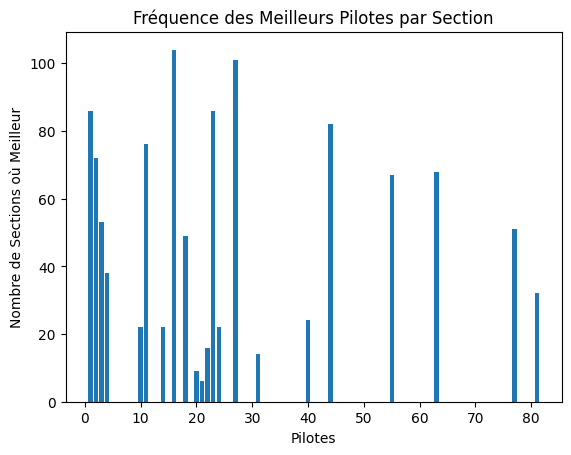

Le pilote dominant pour ce circuit est : 16


In [22]:

# Faire des prédictions
y_pred = model.predict(X_data)
y_pred_classes = y_pred.argmax(axis=-1).flatten()

# Décoder les prédictions pour obtenir les noms/numéros des pilotes
y_pred_drivers = label_encoder.inverse_transform(y_pred_classes)

# Calculer la fréquence des meilleurs pilotes
unique, counts = np.unique(y_pred_drivers, return_counts=True)
driver_counts = dict(zip(unique, counts))

# Afficher les résultats
plt.bar(driver_counts.keys(), driver_counts.values())
plt.xlabel('Pilotes')
plt.ylabel('Nombre de Sections où Meilleur')
plt.title('Fréquence des Meilleurs Pilotes par Section')
plt.show()

# Pilote dominant
dominant_driver = max(driver_counts, key=driver_counts.get)
print(f"Le pilote dominant pour ce circuit est : {dominant_driver}")
